# Поиск по изображениям

**Заказчик** -  фотохостинг для профессиональных фотографов «Со Смыслом» (“With Sense”).

Пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т. д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала.

Отдел занимается экспериментом по разработке поиска референсных фотографий для фотографов. Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены. Например, такое:
> A man is crossing a mountain pass on a metal bridge.

Сервис выводит несколько фотографий с такой же или похожей сценой.

**Цель проекта** - выбрать лучшую  модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу.

**Описание данных**

- В файле train_dataset.csv находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.
- В папке train_images содержатся изображения для тренировки модели.
- В файле CrowdAnnotations.tsv  — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:
    - Имя файла изображения.
    - Идентификатор описания.
    - Доля людей, подтвердивших, что описание соответствует изображению.
    - Количество человек, подтвердивших, что описание соответствует изображению.
    - Количество человек, подтвердивших, что описание не соответствует изображению.
- В файле ExpertAnnotations.tsv  — данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:
    - Имя файла изображения.
    - Идентификатор описания.
    - 3, 4, 5 — оценки трёх экспертов (эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью).      
- В файле test_queries.csv находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.
- В папке test_images содержатся изображения для тестирования модели.


**Задачи проекта**


1. Загрузить данные и провести исследовательский анализ данных.
2. Подготовить данные к обучению модели.
3. Обучить модель.
4. Протестировать модель и продемонстрировать ее работу.
5. Сделать общий вывод по работе.

В качестве моделей обязательно нужно рассмотреть:
1. Линейную регрессию;
2. Полносвязные нейронные сети.

При решении задачи необходимо использовать только один фреймворк  Pytorch или Keras.

*Юридические ограничения*

В некоторых странах, где работает компания With Sense, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет. Во время тестирования модели при появлении в запросе “вредного” контента должен отображаться дисклеймер.




## Импорт библиотек

In [ ]:
import os
import warnings
import time
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pathlib import Path
import math

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from textwrap import wrap
from PIL import Image

from tqdm import tqdm
from tqdm import notebook
tqdm.pandas()

import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from collections import defaultdict
nltk.download('averaged_perceptron_tagger')
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error

from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization, Reshape, RepeatVector, LSTM, Dropout
from tensorflow.keras.optimizers import Adam




Using TensorFlow backend


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\js\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Загрузка данных

In [ ]:
PATH = 'C:/Users/js/OneDrive/Рабочий стол/to_upload'

In [ ]:
train_data = pd.read_csv(os.path.join(PATH, 'train_dataset.csv'))
train_data.name = 'train_data'
data_crowd = pd.read_csv(os.path.join(PATH, 'CrowdAnnotations.tsv'), sep='\t', names = ['image', 'query_id', 'conf_rate', 'confirm', 'not_confirm'])
data_crowd.name = 'data_crowd'
data_expert = pd.read_csv(os.path.join(PATH, 'ExpertAnnotations.tsv'), sep='\t', names = ['image', 'query_id', 'exp_1', 'exp_2', 'exp_3'])
data_expert.name = 'data_expert'
test_query = pd.read_csv(os.path.join(PATH, 'test_queries.csv'), index_col=[0], sep='|')
test_query.name = 'test_query'
test_images = pd.read_csv(os.path.join(PATH, 'test_images.csv'))
test_images.name = 'test_images'

In [ ]:
def show_data(df):
    print('\033[1m' + df.name + "\033[0;0m")
    print(df.shape)
    print()
    print(df.info())
    display(df.head())
    print('-'*120)
    print()

for df in [train_data, data_crowd, data_expert, test_query, test_images]:
    show_data(df)

train_data
(5822, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB
None


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

------------------------------------------------------------------------------------------------------------------------

data_crowd
(47830, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        47830 non-null  object 
 1   query_id     47830 non-null  object 
 2   conf_rate    47830 non-null  float64
 3   confirm      47830 non-null  int64  
 4   not_confirm  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB
None


image                     query_id  conf_rate  confirm  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0        3   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0        0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0        0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0        0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0        0   

   not_confirm  
0            0  
1            3  
2            3  
3            3  
4            3

------------------------------------------------------------------------------------------------------------------------

data_expert
(5822, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   exp_1     5822 non-null   int64 
 3   exp_2     5822 non-null   int64 
 4   exp_3     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB
None


image                     query_id  exp_1  exp_2  exp_3
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1      1      1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1      1      2
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1      1      2
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1      2      2
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1      1      2

------------------------------------------------------------------------------------------------------------------------

test_query
(500, 3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB
None


query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

------------------------------------------------------------------------------------------------------------------------

test_images
(100, 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes
None


image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

------------------------------------------------------------------------------------------------------------------------



## Подготовка данных

### Объединение таблиц в одну тренировочную выборку

Для расчета агрегированной оценки экспертов, возмем медианную оценку всех экспертов. Используем масштабирование min-max для перевода оценок в диапазон [0,1]

In [ ]:
data_expert['exp_total'] = (data_expert[['exp_1', 'exp_2', 'exp_3']]).median(axis=1)

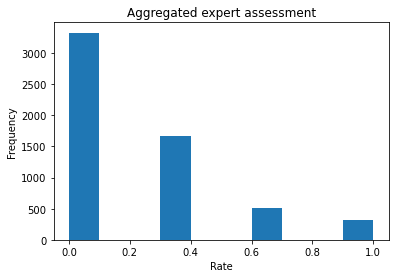

In [ ]:
data_expert['exp_norm'] = (data_expert['exp_total'] - data_expert['exp_total'].min()) / (data_expert['exp_total'].max() - data_expert['exp_total'].min())

data_expert['exp_norm'].plot.hist()
plt.title('Aggregated expert assessment')
plt.xlabel('Rate')
plt.show()

Большинство изображений в датасете не соответствует описанию.

In [ ]:
train_dataset = train_data.copy()

In [ ]:
train_data = train_data\
.merge(data_expert[['image', 'query_id', 'exp_norm']], how='left', on=['image', 'query_id'])\
.merge(data_crowd[['image', 'query_id', 'conf_rate']], how='outer', on=['image', 'query_id'])
train_data.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  exp_norm  conf_rate  
0  A young child is wearing blue goggles and sitt...  0.000000        0.0  
1  A young child is wearing blue goggles and sitt...  0.000000        NaN  
2  A young child is wearing blue goggles and sitt...  0.333333        0.0  
3  A young child is wearing blue goggles and sitt...  1.000000        1.0  
4  A young child is wearing blue goggles and sitt...  0.000000        NaN

In [ ]:
query_id_text_corresp = train_dataset[['query_id', 'query_text']].drop_duplicates()

train_data = train_data.drop(columns=['query_text']).merge(query_id_text_corresp, how="left", on=['query_id'])

Рассчитаем среднюю оценку для создания целевого признака.

In [ ]:
train_data['target'] = train_data[['conf_rate', 'exp_norm']].mean(axis=1)
train_data = train_data.drop(columns=['conf_rate', 'exp_norm'])
train_data.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text    target  
0  A young child is wearing blue goggles and sitt...  0.000000  
1  A young child is wearing blue goggles and sitt...  0.000000  
2  A young child is wearing blue goggles and sitt...  0.166667  
3  A young child is wearing blue goggles and sitt...  1.000000  
4  A young child is wearing blue goggles and sitt...  0.000000

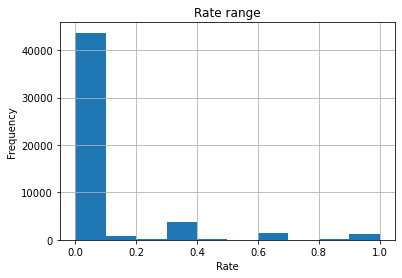

In [ ]:
train_data['target'].hist()
plt.title('Rate range')
plt.xlabel('Rate')
plt.ylabel('Frequency')
plt.show()

Просмотрим изображения, которые по общей оценке соответствуют описанию и  не соответствуют.

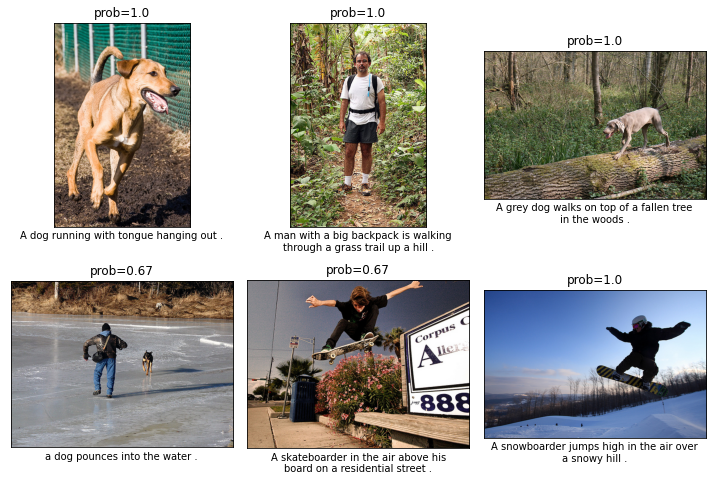

In [ ]:
sample_data = train_data.sample(n=2000, random_state=0)
negative = sample_data[sample_data['target'] <= 0.5]
positive = sample_data[sample_data['target'] > 0.5]
fig = plt.figure(figsize=(10,10))
for i in range(6):
    fig.add_subplot(3, 3, i+1)
    img_name = positive.iloc[i]['image']
    img_text = positive.iloc[i]['query_text']
    img_text = '\n'.join(wrap(str(img_text), 40))

    img_target = positive.iloc[i]['target']


    img = mpimg.imread(f'{PATH}/train_images/{img_name}')
    plt.imshow(img)
    plt.title(f'prob={round(img_target, 2)}')
    plt.xlabel(img_text)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()


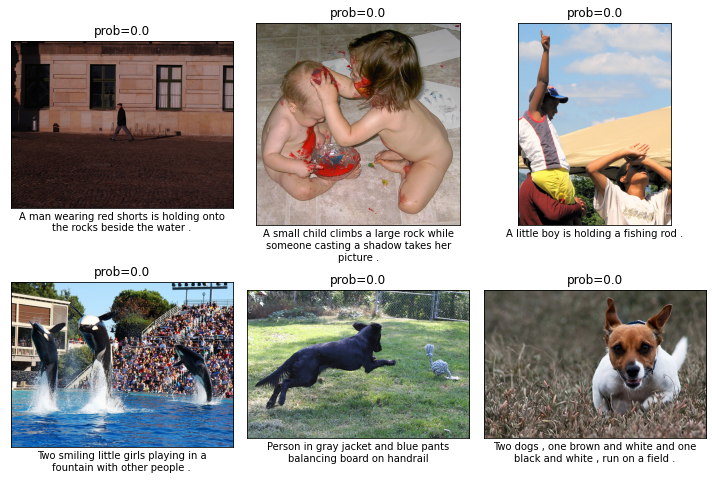

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(6):
    fig.add_subplot(3, 3, i+1)
    img_name = negative.iloc[i]['image']
    img_text = negative.iloc[i]['query_text']
    img_text = '\n'.join(wrap(str(img_text), 40))
    img_target = negative.iloc[i]['target']
    img = mpimg.imread(f'{PATH}/train_images/{img_name}')
    plt.imshow(img)
    plt.title(f'prob={round(img_target, 2)}')
    plt.xlabel(img_text)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

По визуализации результат приемлемый, посмотрим, насколько точно справится модель, обученная на наших данных.

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51323 non-null  object 
 1   query_id    51323 non-null  object 
 2   query_text  50214 non-null  object 
 3   target      51323 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.0+ MB


Пропущенные значения в query_text составляют около 2%, данные можно удалить.

In [ ]:
train_data = train_data.dropna()

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50214 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       50214 non-null  object 
 1   query_id    50214 non-null  object 
 2   query_text  50214 non-null  object 
 3   target      50214 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


In [ ]:
train_data.duplicated().sum()

0

In [ ]:
train_data.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text    target  
0  A young child is wearing blue goggles and sitt...  0.000000  
1  A young child is wearing blue goggles and sitt...  0.000000  
2  A young child is wearing blue goggles and sitt...  0.166667  
3  A young child is wearing blue goggles and sitt...  1.000000  
4  A young child is wearing blue goggles and sitt...  0.000000

## Установка юридических ограничений

In [ ]:
w_t_b = ['child', 'boy', 'girl', 'baby', 'teen', 'teenager', 'kid', 'infant', 'youngster', 'kids', 'children', 'boys', 'girls', 'babies', 'teens', 'teenagers']

Выполним предобработку текста и найдем запрещенные слова.

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
def preproc(text):
    text = re.sub(r'[^a-zA-z ]', ' ', text)
    text = text.lower()
    token = nltk.word_tokenize(text)
    text = [word for word in token if word not in stop_words]
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    tag_map['R'] = wn.NOUN
    text = [lemmatizer.lemmatize(word, tag_map[tag[0]]) for word, tag in pos_tag(text)]
    text = ' '.join(text)
    return text

In [ ]:
train_data['preproc'] = train_data['query_text'].progress_apply(preproc)
train_data.head()

100%|███████████████████████████████████████████████████████████████████████████| 50214/50214 [01:18<00:00, 640.06it/s]


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text    target  \
0  A young child is wearing blue goggles and sitt...  0.000000   
1  A young child is wearing blue goggles and sitt...  0.000000   
2  A young child is wearing blue goggles and sitt...  0.166667   
3  A young child is wearing blue goggles and sitt...  1.000000   
4  A young child is wearing blue goggles and sitt...  0.000000   

                                        preproc  
0  young child wear blue goggles sit float pool  
1  young child wear blue goggles sit float pool  
2  young child wear blue goggles sit float pool  
3  young child wear blue goggles sit float pool  
4  young child wear blue goggles sit float pool

In [ ]:
def blocking(row):

    phrase = row['preproc']
    bin_array = [i for i in phrase.split() if i in w_t_b]
    if bin_array:
        row['word_to_block'] = 1
    else:
        row['word_to_block'] = 0

    return row

train_data = train_data.progress_apply(blocking, axis=1)

train_data.head()

100%|██████████████████████████████████████████████████████████████████████████| 50214/50214 [00:45<00:00, 1115.54it/s]


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text    target  \
0  A young child is wearing blue goggles and sitt...  0.000000   
1  A young child is wearing blue goggles and sitt...  0.000000   
2  A young child is wearing blue goggles and sitt...  0.166667   
3  A young child is wearing blue goggles and sitt...  1.000000   
4  A young child is wearing blue goggles and sitt...  0.000000   

                                        preproc  word_to_block  
0  young child wear blue goggles sit float pool              1  
1  young child wear blue goggles sit float pool              1  
2  young child wear blue goggles sit float pool              1  
3  young child wear blue goggles sit float pool              1  
4  young child wear blue goggles sit float pool              1

Посмотрим на заблокированные изображения, чтобы убедиться в корректности функции.

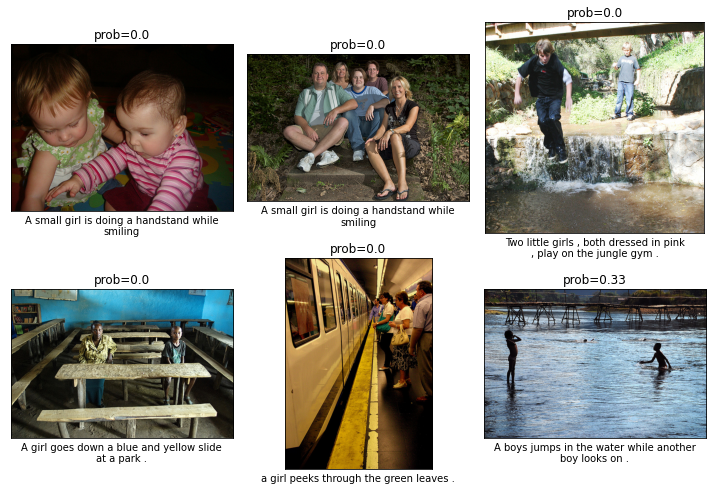

In [ ]:
sample_data = train_data.sample(n=2000, random_state=0)
negative = sample_data[sample_data['word_to_block'] == 1]

fig = plt.figure(figsize=(10,10))
for i in range(6):
    fig.add_subplot(3, 3, i+1)
    img_name = negative.iloc[i]['image']
    img_text = negative.iloc[i]['query_text']
    img_text = '\n'.join(wrap(str(img_text), 40))

    img_target = negative.iloc[i]['target']


    img = mpimg.imread(f'{PATH}/train_images/{img_name}')
    plt.imshow(img)
    plt.title(f'prob={round(img_target, 2)}')
    plt.xlabel(img_text)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Удалим запрещенные данные.

In [ ]:
train_data = train_data.loc[train_data['word_to_block'] == 0]
train_data.drop(columns=['word_to_block'], inplace=True)

In [ ]:
train_data.duplicated().sum()

0

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36125 entries, 22 to 51322
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       36125 non-null  object 
 1   query_id    36125 non-null  object 
 2   query_text  36125 non-null  object 
 3   target      36125 non-null  float64
 4   preproc     36125 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.7+ MB


### Векторизация

**1. Векторизация изображений.**

In [ ]:
train_data_clear = train_data.drop('query_id', axis=1)

Found 36125 validated image filenames.


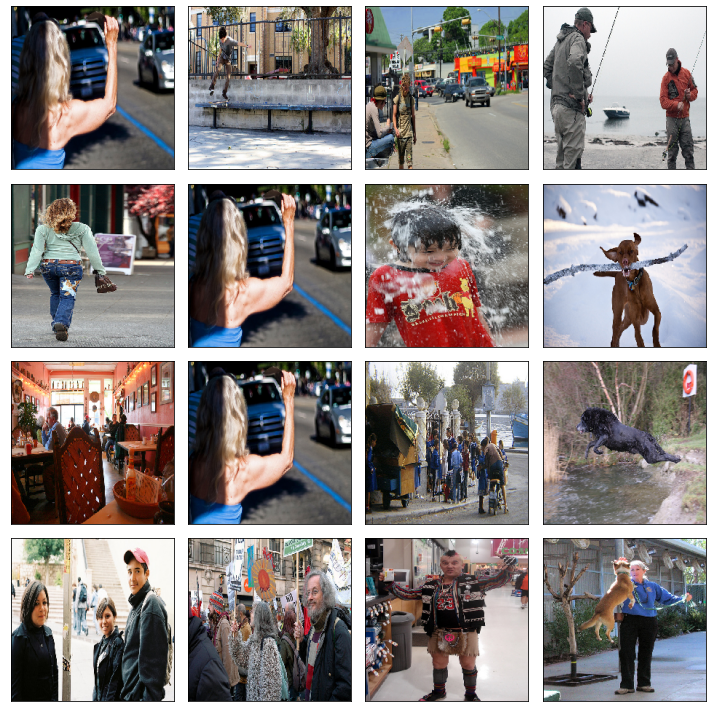

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory=Path(PATH, 'train_images'),
        x_col='image',
        y_col='score',
        target_size=(224, 224),
        batch_size=16,
        class_mode='input',
        shuffle=False, seed=12345)

features, target = train_gen_flow.next()

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

In [ ]:
def create_model():
    backbone = ResNet50(input_shape=(224, 224, 3),
                        include_top=False,
                        weights='imagenet')

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0001), metrics=['mae'])

    return model

In [ ]:
def image_vectorization(model, train_data):
    predictions = model.predict(train_data)
    return predictions

In [ ]:
image_embedings = image_vectorization(create_model(), train_gen_flow)
image_embedings.shape

2258/2258 [==============================] - 4424s 2s/step


(36125, 2048)

**2. Векторизация текста.**

In [ ]:
tfidf = TfidfVectorizer()

In [ ]:
tfidf_train_data = tfidf.fit_transform(train_data['preproc'])

In [ ]:
tfidf_train_data.shape

(36125, 976)

Размерности двух векторов совпадают (по первому числу, 36125).

**3. Объединение векторов.**

In [ ]:
tfidf_train_data = tfidf_train_data.toarray()

In [ ]:
features = np.concatenate((image_embedings, tfidf_train_data), axis=1)
features.shape

(36125, 3024)

In [ ]:
target = np.array(train_data['target'])
target.shape

(36125,)

По итогам конкотенации двух векторных представлений у нас получился массив с 36125 наблюдениями, признаков - 3024.

## Обучение модели

Среднеквадратичная ошибка хорошо подходит для задач регрессии, где необходимо оценить отклонение предсказанных значений от истинных значений в тех же единицах измерения. RMSE чувствительнее к выбросам, чем MAE, и поэтому может быть более точным показателем производительности модели в случаях, когда наблюдаются большие различия между истинными значениями и предсказаниями. Для оценки моделей будем использовать эту метрику.

**1. Разделение на обучающую и тестовую выборки.**

Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки. Воспользуемся классом GroupShuffleSplit из библиотеки sklearn.model_selection, чтобы учесть изображения при разбиении и избежать переобучения.

In [ ]:
groups = train_data['image']

gss = GroupShuffleSplit(n_splits=1, train_size=.6, random_state=12345)
train_ind, test_ind = next(gss.split(X=features, y=target, groups=groups))

features_train, features_test = features[train_ind], features[test_ind]
target_train, target_test = target[train_ind], target[test_ind]

In [ ]:
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(21365, 3024) (14760, 3024) (21365,) (14760,)


In [ ]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

**2. Линейная регрессия.**

За baseline возьмём линейную регрессию с регуляризацией L2.

In [ ]:
model_r = Ridge().fit(features_train, target_train)
predictions = model_r.predict(features_test)
np.sqrt(np.sqrt(mean_squared_error(target_test, predictions)))

1.1398616880653256

In [ ]:
model_lr = LinearRegression().fit(features_train, target_train)
predictions = model_lr.predict(features_test)
np.sqrt(np.sqrt(mean_squared_error(target_test, predictions)))


4652498.517270994

Линейная регрессия ошибается почти в половине случаев, как и baseline. Посмотрим нейронную сеть, думаю подбирать параметры смысла нет.

**3. NN.**

In [ ]:
model_nn = Sequential()
model_nn.add(Dense(1024, activation='relu', input_shape=(3024,)))
model_nn.add(BatchNormalization())
model_nn.add(Dense(512, activation='tanh'))
model_nn.add(Dropout(0.2))
model_nn.add(Dense(256, activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(128, activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(64, activation='relu'))
model_nn.add(Flatten())
model_nn.add(Dense(1, activation='linear'))


model_nn.compile(loss='mean_squared_error',
                optimizer = Adam(lr=0.0001),
                metrics=[RootMeanSquaredError()])

In [ ]:
model_nn.fit(features_train,
             target_train,
             epochs=8,
             batch_size=32,
             validation_data=(features_test, target_test),
             validation_steps = math.ceil(features_train.shape[1]/32),
             verbose=2)

Epoch 1/8
668/668 - 17s - loss: 0.2545 - root_mean_squared_error: 0.5045 - val_loss: 0.1361 - val_root_mean_squared_error: 0.3689 - 17s/epoch - 25ms/step
Epoch 2/8
668/668 - 15s - loss: 0.1004 - root_mean_squared_error: 0.3168 - val_loss: 0.1029 - val_root_mean_squared_error: 0.3208 - 15s/epoch - 23ms/step
Epoch 3/8
668/668 - 15s - loss: 0.0694 - root_mean_squared_error: 0.2635 - val_loss: 0.0815 - val_root_mean_squared_error: 0.2854 - 15s/epoch - 23ms/step
Epoch 4/8
668/668 - 16s - loss: 0.0577 - root_mean_squared_error: 0.2403 - val_loss: 0.0741 - val_root_mean_squared_error: 0.2722 - 16s/epoch - 23ms/step
Epoch 5/8
668/668 - 16s - loss: 0.0510 - root_mean_squared_error: 0.2259 - val_loss: 0.0724 - val_root_mean_squared_error: 0.2691 - 16s/epoch - 24ms/step
Epoch 6/8
668/668 - 15s - loss: 0.0475 - root_mean_squared_error: 0.2179 - val_loss: 0.0726 - val_root_mean_squared_error: 0.2695 - 15s/epoch - 23ms/step
Epoch 7/8
668/668 - 15s - loss: 0.0449 - root_mean_squared_error: 0.2119 - v

Разность между предсказанными и наблюдаемыми значениями в модели около 0.26 rmse, результат приемлемый, проверим на тестовой выборке.

## Тестирование

**1. Векторизация.**

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_gen_flow = train_datagen.flow_from_dataframe(
        dataframe = test_images,
        directory = Path(PATH, 'test_images'),
        x_col ='image',
        y_col ='score',
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'input',
        shuffle=False, seed=12345)

Found 100 validated image filenames.


In [ ]:
image_embedings = image_vectorization(create_model(), test_gen_flow)
image_embedings.shape

7/7 [==============================] - 20s 3s/step


(100, 2048)

In [ ]:
tfidf_test_data = tfidf.transform(test_query['query_text']).toarray()

In [ ]:
tfidf_test_data.shape

(500, 976)

**2. Предсказание.**

In [ ]:
def inference(text):

    # юридический фильтр
    bin_array = [i for i in preproc(text).split() if i in w_t_b]
    if bin_array:
        print('-'*100)
        print()
        print(text)
        print()
        print('#'*77)
        s = 'This image is unavailable in your country in compliance with local laws'.upper()
        print(f'## {s} ##')
        print('#'*77)
        print()


    else:
        # предсказание модели
        emb = tfidf.transform([preproc(text)]).toarray()
        feature = np.concatenate((image_embedings, np.resize(emb, (image_embedings.shape[0],976))), axis=1)
        feature = scaler.transform(feature)
        predictions = model_nn.predict(feature)


        # добавление предсказаний в датасет и выделение 5 наибольших значений
        data = pd.concat((test_images, pd.Series(np.reshape(predictions, (predictions.shape[0],)), name='predictions')), axis=1)

        top = list(data.sort_values(by='predictions', ascending=False)['image'].head(5))
        top_score = list(data.sort_values(by='predictions', ascending=False)['predictions'].head(5))

        # вывод текста
        print()
        print(text)
        print()

        # визуализация изображений с наиболее высокой вероятностью соответствия
        fig = plt.figure(figsize=(15,6))
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['axes.linewidth'] = 0
        for i in range(5):
            fig.add_subplot(1, 6, i+1, title=round(top_score[i], 2))
            image = Image.open(Path(PATH, 'test_images', top[i]))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()

        # вывод целевого изображения
        if text in list(test_query['query_text']):
            plt.rcParams['axes.edgecolor'] = 'green'
            plt.rcParams['axes.linewidth'] = 5
            fig.add_subplot(1, 6, 6)
            image = Image.open(Path(PATH, 'test_images', test_query.iloc[test_query[test_query['query_text'] == text].index[0]]['image']))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            print()

        plt.show()

        print('-'*100)

    return None

4/4 [==============================] - 0s 10ms/step

Three dirt bike racers head over a jump .




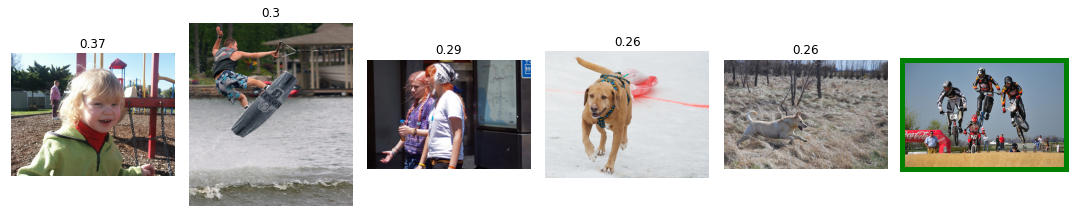

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

a woman dumping water on a small child who is in a pool

#############################################################################
## THIS IMAGE IS UNAVAILABLE IN YOUR COUNTRY IN COMPLIANCE WITH LOCAL LAWS ##
#############################################################################

----------------------------------------------------------------------------------------------------

kids play ultimate Frisbee .

#############################################################################
## THIS IMAGE IS UNAVAILABLE IN YOUR COUNTRY IN COMPLIANCE WITH LOCAL LAWS ##
#############################################################################

----------------------------------------------------------------------------------------------------

Three children stand on or near a fe

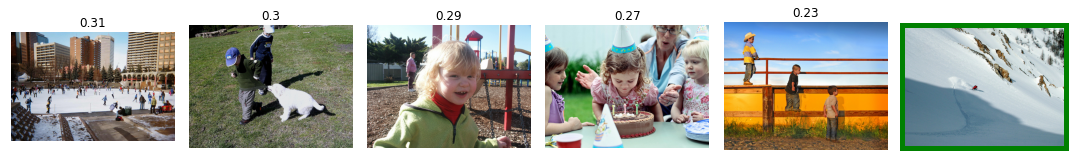

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

kids are playing in water fountains

#############################################################################
## THIS IMAGE IS UNAVAILABLE IN YOUR COUNTRY IN COMPLIANCE WITH LOCAL LAWS ##
#############################################################################

4/4 [==============================] - 0s 10ms/step

The brown dog is wearing a black collar .




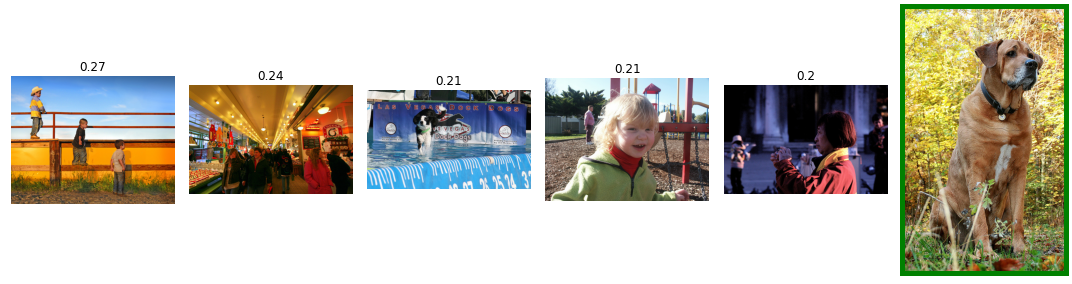

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

The young boy flings mud at the barefoot girl in the pond .

#############################################################################
## THIS IMAGE IS UNAVAILABLE IN YOUR COUNTRY IN COMPLIANCE WITH LOCAL LAWS ##
#############################################################################

----------------------------------------------------------------------------------------------------

A man lies on a blue blanket with a child on his back .

#############################################################################
## THIS IMAGE IS UNAVAILABLE IN YOUR COUNTRY IN COMPLIANCE WITH LOCAL LAWS ##
#############################################################################

4/4 [==============================] - 0s 9ms/step

A man in a blue shirt lifts up his tennis racket and sm

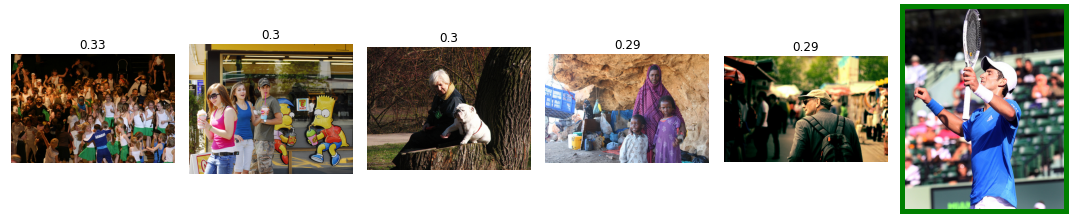

----------------------------------------------------------------------------------------------------


In [ ]:
test_phrases = list(test_query['query_text'].sample(10))
for phrase in test_phrases:
    inference(phrase)

## Вывод

Цель данной работы состояла в создании модели, которая по текстовому описанию должна подбирать наиболее релевантные изображения.

Оценки экспертов и краудсорсинга были аггрегированы и на их основе был сконструирован таргет - оценка схожести описания и изображения. Оценка лежит в диапазоне от нуля до единицы. Метрика качества - RMSE.

Была проверено качество работы линейной регрессии, которая показала не очень хороший результат.

Следующим шагом была проверена работа нейронной сети. Качество, которое она показала за 8 эпох обучения, показалось удовлетворительным - 0.25 rmse. Однако при проверке на тестовых данных модель показала среднее качество. Она выдавала изображения, на которых контекст схож с описанием, однако сходство лишь отдаленное. Только в одном из 8 случаев модель вывела нужную каринку. Один из способов, как можно было бы усовершенствовать модель - убедиться, что для каждого изображения (а также для каждого текстового описания) представлено одинаковое количество пар, отмеченных как "скорее совпадает" и "скорее не совпадает". Дисбаланс, при таком способе обучения, когда мы конкатенируем вектора, может спровоцировать тот факт, что модель начнет переобучаться под определенные изображения либо описания.
